# Исследование продаж игр

В нашем распоряжении находятся взятые из открытых источников данные о продажах игр, оценки пользователей и экспертов.
Задача исследования состоит в том, чтобы выделить определяющие успешность игры закономерности.

**Цель исследования**

- Определить факторы, оказывающие влияние на уровень успешности игры.
- Выделить из них те, чьё влияние наибольшее.

**Ход исследования**

Данные для исследования я получу из датасета `/datasets/games.csv`. О качестве данных ничего не известно, это значит, что в первую очередь необходимо будет провести обзор данных.

Я проверю данные на наличие разжичного рода ошибок. Затем, на этапе предобработки данных, я поищу возможность иправить обнаруженные ошибки, которые способны привести к ложному результату. Далее я постараюсь привести данные к состоянию, в котором с ними наиболее удобно работать, и приступлю к проведению анализа данных.

Таким образом, моё исследование будет состоять из следующих этапов:
- Обзор данных
- Предобработка данных
- Исследовательский анализ данных
- Определение особенностей каждой группы пользоватей
- Проверка гипотез
- Написание общего вывода, подведение итогов.

In [598]:
import math
import numpy as np
import pandas as pd
from scipy import stats as st

import matplotlib.pyplot as plt

## 1. Открытие файла с данными и изучение основной информации

In [599]:
data = pd.read_csv('data_prefab_project_games.csv')

In [600]:
display(data.head())
print(data.info())
print('\nЧисло дубликатов:', data.duplicated().sum())
print(f'\nРазмер датасета: {data.shape[0]} строк и {data.shape[1]} столбцов')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None

Число дубликатов: 0

Размер датасета: 16715 строк и 11 столбцов


Можно заключить, что полностью данные содержатся в столбцах, которые содержат данные о платформе и о продажах: `Platform`, `NA_sales`, `EU_sales`, `JP_sales`, `Other_sales`. В остальных данных есть пропущенные значения, особенно много их в данных о различного рода оценках: `Critic_Score`, `User_Score`, `Rating`.

count     16715
unique       31
top         PS2
freq       2161
Name: Platform, dtype: object


<AxesSubplot:title={'center':'Количество данных по платформам'}, xlabel='Платформы', ylabel='Данные'>

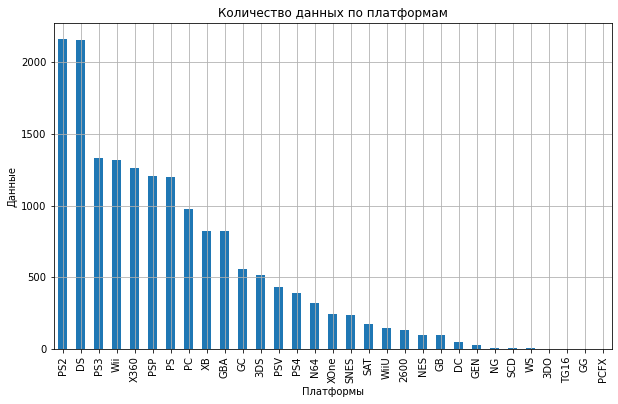

In [601]:
print(data['Platform'].describe())
data['Platform'].value_counts().plot.bar(title = 'Количество данных по платформам',
                                         xlabel = 'Платформы',
                                         ylabel = 'Данные',
                                         figsize = (10, 6),
                                         grid = True)

count    16446.000000
mean      2006.484616
std          5.877050
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: Year_of_Release, dtype: float64


<AxesSubplot:title={'center':'Количество данных по годам'}, ylabel='Frequency'>

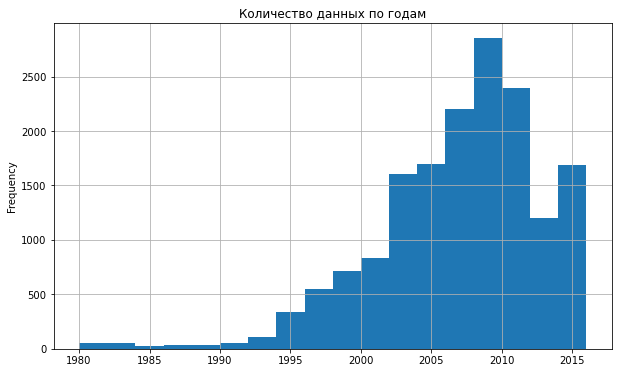

In [602]:
print(data['Year_of_Release'].describe())
data['Year_of_Release'].plot.hist(title = 'Количество данных по годам',
                                  bins = 18,
                                  xlabel = 'Год',
                                  ylabel = 'Данные',
                                  figsize = (10, 6),
                                  grid = True)

count      16713
unique        12
top       Action
freq        3369
Name: Genre, dtype: object


<AxesSubplot:title={'center':'Количество данных по жанрам'}, xlabel='Жанры', ylabel='Данные'>

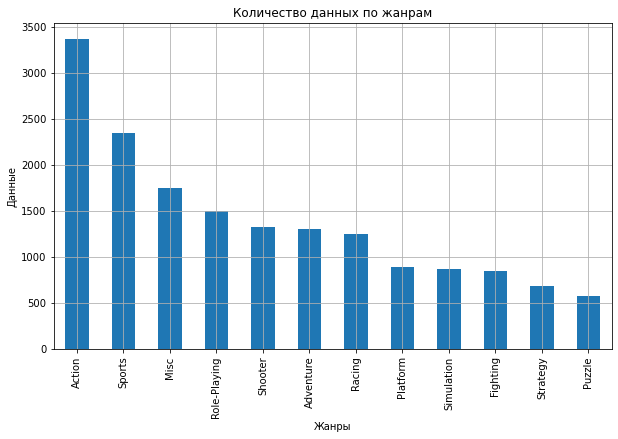

In [603]:
print(data['Genre'].describe())
data['Genre'].value_counts().plot.bar(title = 'Количество данных по жанрам',
                                         xlabel = 'Жанры',
                                         ylabel = 'Данные',
                                         figsize = (10, 6),
                                         grid = True)

**Первые выводы по данным**

Данные однозначно нуждаются в обработке. Обнаружено достаточно много пропущенных значений, типы данных не везде указаны верно. Названия столбцов необходимо привести к классическому виду.

Данные по платформам и жанрам собраны неравномерно. С течением времени количество игр увеличивалось многократно.

## 2. Предобработка данных

### Преобразуем названия столбцов

In [604]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка дубликатов

In [605]:
data.duplicated().sum()

0

In [606]:
len(data['name'])-len(data['name'].drop_duplicates())

5155

В данных не обнаружено явных дубликатов. Обработка неявных дубликатов может проводиться только по столбцу `name`, однако обрабатывать и устранять повторяющиеся значения не имеет смысла, так как крайне маловероятно, что значения действительно являются дубликатом.

### Преобразуем типы данных

Необходимо преобразовать типы данных в двух столбцах:

1. year_of_release нужно заменить с `float` на `int`, так как в рассматриваемом столбце содержатся исключительно данные о годе выхода игры, нет смысла преобразовывать в формат `datetime`.
2. user_score нужно заменить с `str` на `float`, потому что в нём содержатся данные об оценке пользователя, представленные в числовом формате.

In [607]:
# Удалим пустые значения, так как значений немного, однако такая характеристика, как год выхода крайне важна
# data['year_of_release'].fillna(0, inplace = True)
data = data.dropna(subset=['year_of_release']).reset_index(drop = True)
# data['year_of_release'].unique()
data['year_of_release'] = data['year_of_release'].astype(int)

При попытке преобразовать тип данных в столбце `user_score` при помощи `data['user_score'] = data['user_score'].astype(float)`, обнаружились строки, содержащие значения `tbd`, скорее всего это означает "to be determined" - буквально, "предстоит определисть" Рассмотрим эти строки подробнее:

In [608]:
tbd = data[data['user_score'] == 'tbd']['user_score'].count()
not_null = data['user_score'].count()
print('Количество неопределённых оценок:', tbd,
      '\nПроцент неопределённых от общего числа оценок: {:.3%}'.format(tbd/not_null),
      '\nПроцент строк с неопределёнными оценками пользователей от общего числа строк: {:.3%}'.format(tbd/len(data)))

Количество неопределённых оценок: 2376 
Процент неопределённых от общего числа оценок: 24.149% 
Процент строк с неопределёнными оценками пользователей от общего числа строк: 14.447%


Количество таких строк, содержащих `tbd` составляет 14.5% от их общего числа в наборе данных и 24% от общего числа оценок пользователей. Это достаточно большие проценты и просто избавится от них, так, что бы это не отразилось на результате, не получится. Рассмотрим, почему такие данные данные могли получиться, постараемся найти какие-либо особенности, в противном случае, присвоим рассматриваемым значениям тип `NaN` при помощи `np.nan`, так как такие значения в нашем случае равносильны.

In [609]:
data.query('user_score == "tbd"').head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
300,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
516,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
639,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
710,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
717,Dance Dance Revolution X2,PS2,2009,Simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
811,The Incredibles,GBA,2004,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
871,Who wants to be a millionaire,PC,1999,Misc,1.94,0.00,0.00,0.00,NaN,tbd,E
1037,Tetris Worlds,GBA,2001,Puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E
1038,Imagine: Teacher,DS,2008,Simulation,0.70,0.82,0.00,0.19,NaN,tbd,E


Какой-либо закономерности в данных выявить не удалось, значит выполним замену всех значений `tbd` на `NaN`.

In [610]:
data['user_score'].replace('tbd', np.nan, inplace = True)
data['user_score'] = data['user_score'].astype('float')
data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

### Добавление нового столбца

Новый столбец содержит сумму продаж во всех регионах

In [611]:
data.insert(loc = 8, 
            column = 'total_sales', 
            value = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1))
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NaN


### Обработка пустых значений

In [612]:
data.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
total_sales           0
critic_score       8463
user_score         8983
rating             6678
dtype: int64

Видим, что большинство пропусков содержится в столбцах `critic_score`, `user_score` и `rating`.<br>
В столбцах `name` и `genre` так же содержатся пропуски, рассмотрим строки с этими значениями:

In [613]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
652,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,2.39,NaN,NaN,NaN
14022,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,0.03,NaN,NaN,NaN


Ожидаемо, что строки с пропусками в этих значениях взаимосвязаны. Пропущенные значения не являются данными, непосредственно нужными для анализа, в связи с этим, заменим значения на следующие:

`name` -> `unnamed`<br>
`genre` -> `no_genre`

In [515]:
# data.dropna(subset=['name']).reset_index(drop = True)
data.name = data.name.fillna('unnamed')
data.genre = data.genre.fillna('no_genre')
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
total_sales,0.000000
critic_score,51.000000


Прочие столбцы, в которых пропущены ячейки, представляют из себя различного рода рейтинги. Причины пустот в этих столбцах неизвестны, а количество строк с пропусками составляет большой процент от величины всего набора данных. В связи с этим, принято решение не менять ничего в указанных столбцах.

**Итоги предобработки**

В ходе предобработки были:
1. Приведены к нормальному виду названия столбцов данных
2. Преобразованы типы данных в столбцах `user_score` и `year_of_release`
3. Обработаны где нужно пустые значения
4. Добавлен столбец `total_sales` содержащий информацию о продажах во всех регионах
5. разобрано и исправлено значение `tbd` в столбце с оценкой пользователей

## 3. Исследовательский анализ данных

### Распределение игр по годам

In [614]:
data['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

In [615]:
print('Первый год: ', data['year_of_release'].min(),
      '\nПоследний год:', data['year_of_release'].max())

Первый год:  1980 
Последний год: 2016


count    16446.000000
mean      2006.484616
std          5.877050
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64


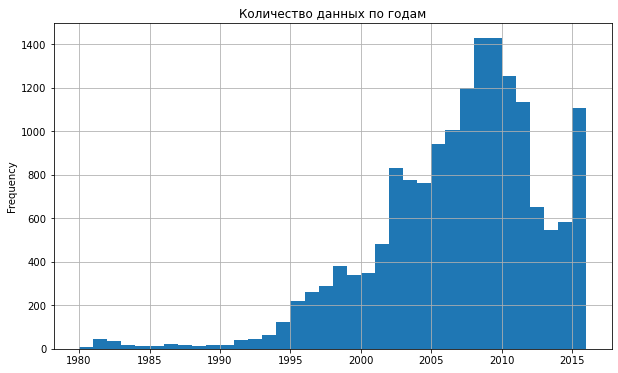

<AxesSubplot:title={'center':'Количество данных по годам'}, ylabel='Данные'>

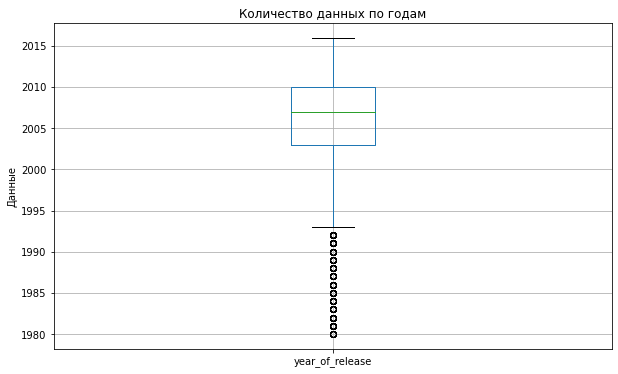

In [517]:
print(data[data['year_of_release'] > 0]['year_of_release'].describe())
data[data['year_of_release'] > 0]['year_of_release'].plot.hist(title = 'Количество данных по годам',
                                  bins = 36,
                                  xlabel = 'Год',
                                  ylabel = 'Данные',
                                  figsize = (10, 6),
                                  grid = True)
plt.show()
data[data['year_of_release'] > 0]['year_of_release'].plot.box(title = 'Количество данных по годам',
                                  xlabel = 'Год',
                                  ylabel = 'Данные',
                                  figsize = (10, 6),
                                  grid = True)

Можно заметить, что число данных до 1996 года сильно уступает прочему количеству.Наибольшееоже число игр приходится на период с 2003 по 2011 год. Рассмотрим данные за эти годы подробнее.

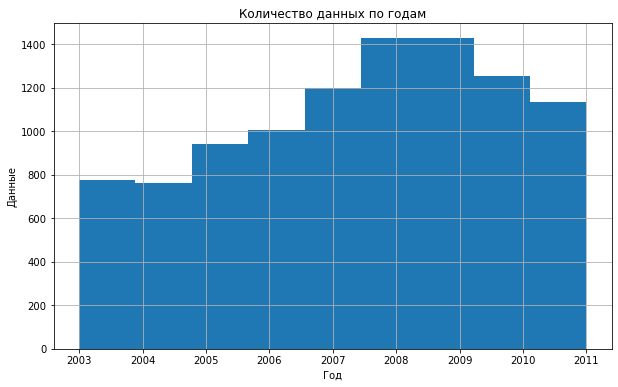

In [518]:
data.query('2003 <= year_of_release <= 2011')['year_of_release'].plot.hist(title = 'Количество данных по годам',
                                                                           bins = 9,
                                                                           figsize = (10, 6),
                                                                           grid = True)
plt.xlabel('Год')
plt.ylabel('Данные')
plt.show()

Видно, что наибольшее количество данных приходится на период с 2003 по 2009 год, а количество данных до 2005 года сильно уступает числу данных за более поздний отрезок времени. Пик приходится на 2008 и 2009 годы.

### Продажи по платформам

#### Продажи по платформам в целом

Text(0, 0.5, 'Суммарные продажи')

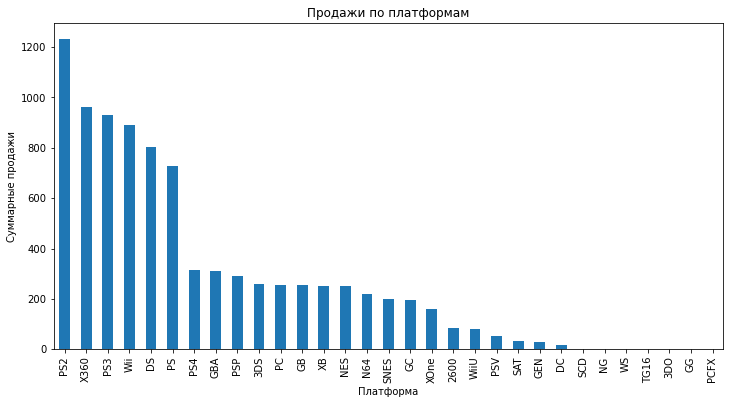

In [519]:
platform_sales = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
platform_sales.plot(kind='bar')
plt.title('Продажи по платформам')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')

Видно, что шесть платформ: PS, DS, Wii, PS3, X360 и PS2 идут с очень большим отрывом от прочих платформ. Будем относить эти платформы в отдельную категорию.

#### Продажи по платформам по годам

In [616]:
best_platforms_sales = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(6)
best_platforms = best_platforms_sales.index.tolist()
print('Лучшие платформы:\n', best_platforms)
print('\nПродажи по лучшим платформам:\n', best_platforms_sales)

Лучшие платформы:
 ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Продажи по лучшим платформам:
 platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
Name: total_sales, dtype: float64


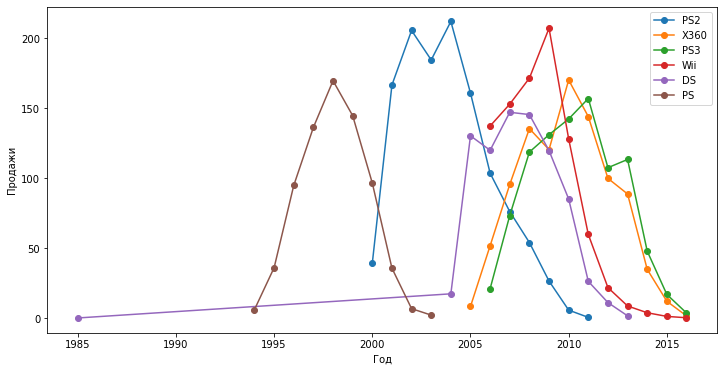

In [617]:
best_platforms_data = data[data['platform'].isin(best_platforms)]
# best_platforms_data
platform_year_sales = best_platforms_data.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
plt.figure(figsize=(12, 6))
for platform in best_platforms:
    platform_data = platform_year_sales[platform_year_sales['platform'] == platform]
    plt.plot(platform_data['year_of_release'], platform_data['total_sales'], marker='o', label=platform)
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.legend()

#### Цикл платформ

In [618]:
platform_time = data.pivot_table(index = 'platform', values = 'year_of_release', aggfunc = ['min', 'max'])
platform_time['time'] = platform_time['max'] - platform_time['min']
mean_time = platform_time['time'].mean()
print(f'Среднее время жизни платформы: {int(mean_time)} лет и {int(mean_time%1*12)} месяцев')

Среднее время жизни платформы: 7 лет и 7 месяцев


### Актуальный период

Как мы определили в заданиях ранее, характерный срок появляются новые и исчезают старые платформы мемного меньше 8 лет. необходимо спрогнозировать данные на 2017 год. Значит, однозначно необходимо брать данные с 2009 года. Более того, ранее мы определили, что наибольшее количество данных по компаниям лежит в периоде с 2005 года, а в последние года это число идёт на спад. Таким образом, расширим выборку расматриваемых значений, пусть актуальные значения  будут взяты за последние 10 лет, то есть с 2007 года.

In [619]:
actual_data = data[(data['year_of_release'] >= 2007)]
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,28.32,87.0,8.4,E
13,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,22.70,80.0,7.7,E
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,21.82,61.0,6.3,E


Как видно на предыдущем графике, продажи по рассматриваемым платформам успели упасть, и крайне маловероятно, что эти платформы смогут снова выстрелить. Скорее всего следует рассмотреть платформы более современные, которые не вошли в топ 10 из-за того, что не успели развиться.

In [565]:
modern_platforms = platform_time[platform_time[('max','year_of_release')] == 2016]
modern_platforms_list = modern_platforms.index.tolist()
modern_platforms_list

['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']

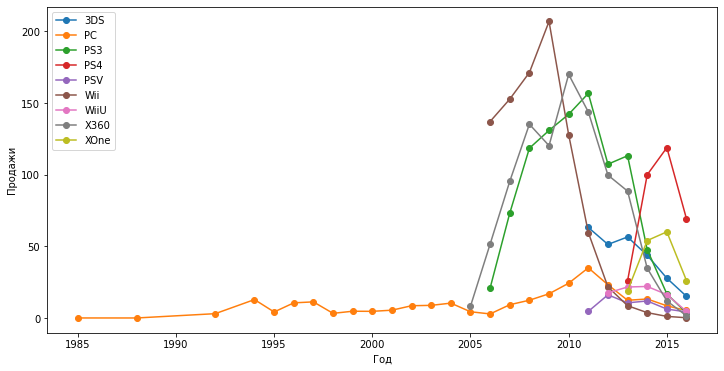

In [620]:
modern_platforms_data = data[data['platform'].isin(modern_platforms_list)]
# modern_platforms_data
platform_year_sales = modern_platforms_data.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
plt.figure(figsize=(12, 6))
for platform in modern_platforms_list:
    platform_data = platform_year_sales[platform_year_sales['platform'] == platform]
    plt.plot(platform_data['year_of_release'], platform_data['total_sales'], marker='o', label=platform)
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.legend()

По графику видно, что продажи по всем платформам упали в 2016 году, однако это означает лишь то, что за 2016 год не успели ещё сформироваться данные. <br>
И тем не менее, по имеющимся данным можно вывделить платформы, продажи по которым с наибольшей вероятностью "взлетят" в ближайшее время, а по каким маловероятно.<br>
**Время платформ _Wii_, _X360_, _PS3_ с наибольшей вероятностью уже подходит к концу**, так показывает их время цикла.
**То же самое можно сказать про _3DS_, _PSV_ и _WIIU_.** Последние две из них просуществовали бОльшую часть среднего цикла не показав выдающихся результатов, а 3DS показывала отрицательный рост с самого начала своего существования.

**Интересны же нам следующие платформы: _PS4_ и _XOne_.** Эти платформы имеют своё начало в 2013 году (то есть совсем недавно), а это значит, что их цикл находится сейчас в самом разгаре, более того, данные за прошедшие годы их существования говорят не просто о положительном росте этих платформ, но и о том, что этот рост достаточно стремительный.

**Отдельное внимание стоит уделить платформе _PC_.** Не смотря на то, что в настоящее время продажи не могут показать выдающихся результатов, эта платформа является крайне стабильной: она существует с 1985 года и её цикл, судя по всему, совершенно не намерен прекращаться, более того, периодические подъемы платформы свидетельствуют о том, что платформа активно поддерживается.

Итак, особое внимание уделить платформам **_PS4_**, **_XOne_** и **_PC_**

### Диаграмма размаха

Рассмотрим более подробно и сравним продажи по играм за актуальныйй промежуток времени:

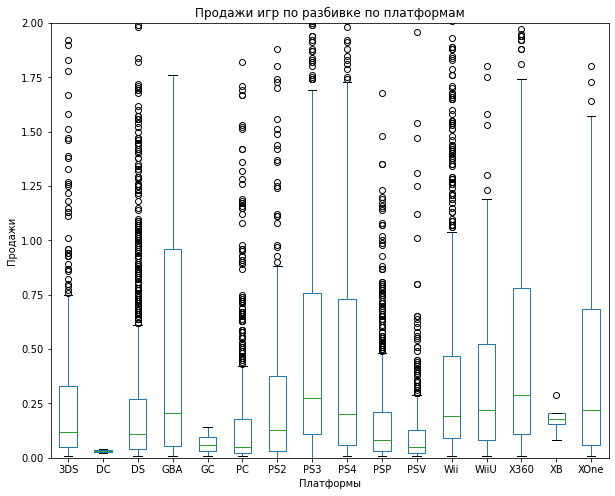

In [621]:
actual_data.groupby(['name', 'platform'])['total_sales'].sum().unstack().plot(kind='box', figsize = (10, 8))
plt.ylim(0, 2)
plt.title('Продажи игр по разбивке по платформам')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

Судя по диаграмме, предположение на счёт платформ **_XOne_** и **_PS4_** оказалось верным, платформы действительно показывают очень высокие результаты

### Влияние отзывов критиков и пользователей на продажи

В наших рейтингах наблюдалась платформа **_PS3_**, продажи по этой платформе показали хороший результат, на её примере проведём анализ влияния.

In [568]:
def sales_eval(platform):
    """
    Строит корреляционную матрицу по платформе, которую указывает пользователь.
    Матрица строится по трем параметрам: оценка пользователей, оценка критиков и продажи.
    """
    corr_matrix = actual_data[actual_data['platform'] == platform][['critic_score','user_score', 'total_sales']].corr()
    return corr_matrix

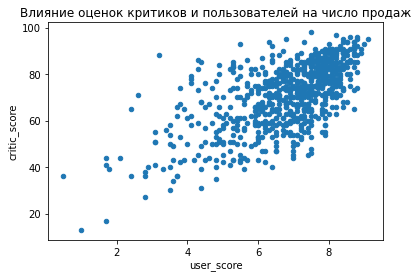

Матрица корреляций


,critic_score,user_score,total_sales
critic_score,1.00000,0.630960,0.433460
user_score,0.63096,1.000000,0.126033
total_sales,0.43346,0.126033,1.000000


In [569]:
actual_data[actual_data['platform'] == 'PS3'].plot(x='user_score', y='critic_score', kind='scatter')
plt.title('Влияние оценок критиков и пользователей на число продаж')
plt.show()
print('Матрица корреляций')
sales_eval('PS3')

По диаграмме видно, что критики и пользователи оценивают платформу приблизительно на одном уровне.<br>
Количество продаж обладает малой корреляцией с оценками критиков и практически нет связи с оценками пользователей.

### Продажи игр на других платформах

Как уже говорилось ранее, нам интересны платформы **_PS4_**, **_XOne_** и **_PC_**, оценим параметры продаж игр на них.

In [570]:
print('Оценка продаж PS4')
display(sales_eval('PS4'))
print('\nОценка продаж XOne')
display(sales_eval('XOne'))
print('\nОценка продаж PC')
sales_eval('PC')

Оценка продаж PS4


,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000



Оценка продаж XOne


,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000



Оценка продаж PC


,critic_score,user_score,total_sales
critic_score,1.000000,0.518416,0.299516
user_score,0.518416,1.000000,-0.009642
total_sales,0.299516,-0.009642,1.000000


По всем платформам можно сделать один вывод:

Oценки пользователей совершенно не влияют на продажи платформ. <br>
Оценки критиков на продажи влияют, но не сильно. При чём оценки критиков влияют на продажи **_PS4_** и **_XOne_** практически на одном уровне, а на продажи **_PC_** они оказывают меньшее влияние.

### Общее распределение игр по жанрам

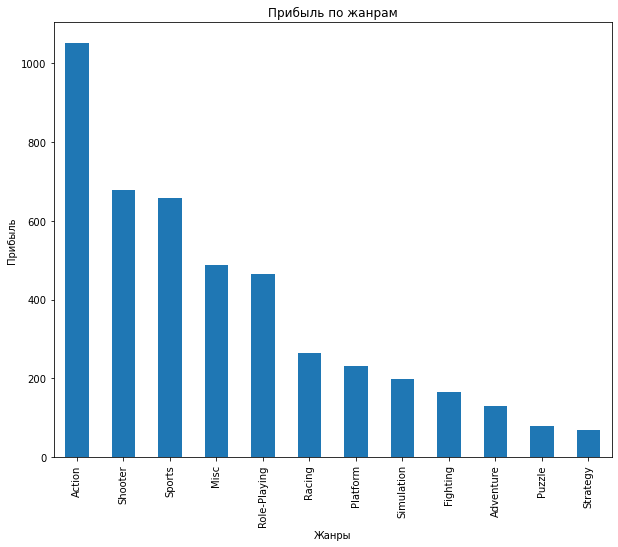

In [571]:
actual_data.groupby('genre')['total_sales'].sum().sort_values(ascending = False).plot(kind='bar', figsize = (10, 8))
plt.title('Прибыль по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Прибыль')
plt.show()

Судя по данным, самые прибыльными жанрами являются `action`, `shooter` и `sport`, при чем первый из них имеет приличный отрыв от прочих. Наименьшую прибыль предоставляют жанры `puzzle` и `strategy`.

**Вывод по исследовательскому анализу**

1. Больше всего игр вышло с 2003 по 2009 годы. Пик приходится на 2008 и 2009 годы. 
2. Самые большие продажи за всё время наблюдались у платформ PS, DS, Wii, PS3, X360 и PS2.
3. Характерный срок за который появляются новые и исчезают старые платформы составляет 7 лет и 7 месяцев.
4. Перспективные и неперспективные платформы:
    - Неперспективные:
        - Wii, X360, PS3, 3DS, PSV, WIIU
    - Перспективные
        - PS4, XOne, PC
5. Оценки пользователей и критиков:
    - Оценки пользователей не влияют на продажи платформ PS4, XOne, PC.
    - Оценки критиков не сильно влияют на продажи платформ PS4, XOne, PC. Их влияние на PC меньше, чем на PS4, XOne.
6. Прибыльность жанров:
    - Самые прибыльные жанры: action, shooter, sport.
    - Наименее прибыльные жанры: puzzle, strategy.

## 4. Составление портрета пользователя каждого региона

### Топ-5 самых популярных платформ для пользователя  каждого региона.

In [572]:
top_region_platforms = actual_data.pivot_table(index = 'platform',
                                        values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                        aggfunc = 'sum')
top_region_platforms.head(3)

,eu_sales,jp_sales,na_sales,other_sales
platform,,,,
3DS,61.27,100.62,82.65,13.27
DC,0.00,0.06,0.00,0.00
DS,119.92,102.93,273.98,38.71


In [573]:
def top_five_plarforms(region_sales):
    """
    Показывает топ-5 платформ для выбранного региона.
    """
    top_five_region_platforms = top_region_platforms[region_sales].sort_values(ascending = False).head(5)
    return pd.DataFrame(top_five_region_platforms)

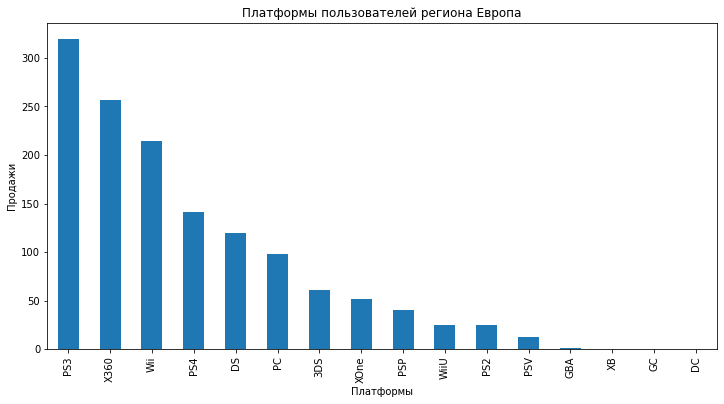

,eu_sales
platform,
PS3,319.83
X360,257.05
Wii,214.70
PS4,141.09
DS,119.92


In [574]:
top_region_platforms['eu_sales'].sort_values(ascending = False).plot.bar(figsize = (12, 6))
plt.title('Платформы пользователей региона Европа')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()
top_five_plarforms('eu_sales')

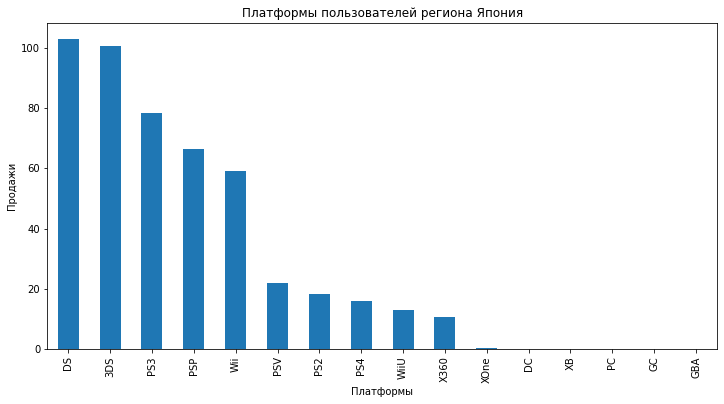

,jp_sales
platform,
DS,102.93
3DS,100.62
PS3,78.33
PSP,66.24
Wii,59.13


In [575]:
top_region_platforms['jp_sales'].sort_values(ascending = False).plot.bar(figsize = (12, 6))
plt.title('Платформы пользователей региона Япония')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()
top_five_plarforms('jp_sales')

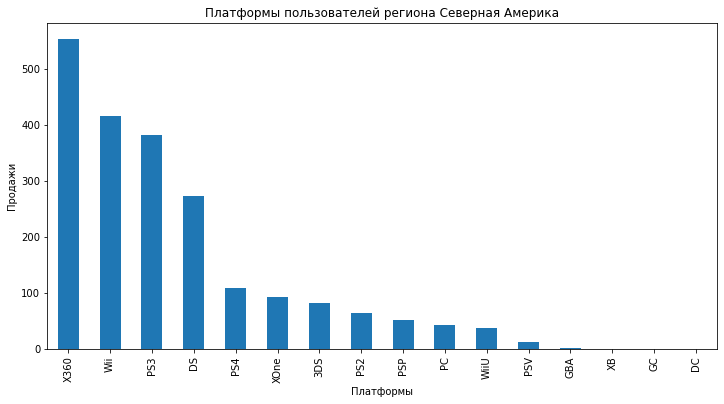

,na_sales
platform,
X360,553.68
Wii,416.01
PS3,381.29
DS,273.98
PS4,108.74


In [576]:
top_region_platforms['na_sales'].sort_values(ascending = False).plot.bar(figsize = (12, 6))
plt.title('Платформы пользователей региона Северная Америка')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()
top_five_plarforms('na_sales')

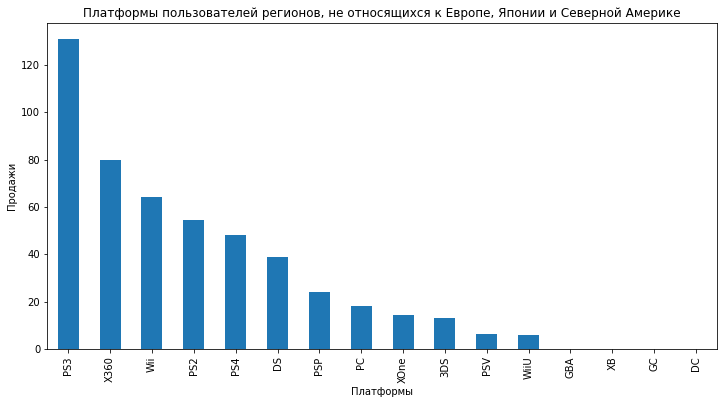

,other_sales
platform,
PS3,130.93
X360,79.82
Wii,64.19
PS2,54.46
PS4,48.35


In [577]:
top_region_platforms['other_sales'].sort_values(ascending = False).plot.bar(figsize = (12, 6))
plt.title('Платформы пользователей регионов, не относящихся к Европе, Японии и Северной Америке')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()
top_five_plarforms('other_sales')

In [578]:
sales_per_region_dict = {'Сумма продаж по топ-5 платформам в регионе Европа:':
                         int(top_five_plarforms('eu_sales')['eu_sales'].sum()),
                         'Сумма продаж по топ-5 платформам в регионе Япония:':
                         int(top_five_plarforms('jp_sales')['jp_sales'].sum()),
                         'Сумма продаж по топ-5 платформам в регионе Северная Америка:':
                         int(top_five_plarforms('na_sales')['na_sales'].sum()),
                         'Сумма продаж по топ-5 платформам в регионах не относящихся к Европе, Японии и Северной Америке':
                         int(top_five_plarforms('other_sales')['other_sales'].sum())}
for s in sorted(sales_per_region_dict, key = sales_per_region_dict.get):
    print(s, sales_per_region_dict[s])

Сумма продаж по топ-5 платформам в регионах не относящихся к Европе, Японии и Северной Америке 377
Сумма продаж по топ-5 платформам в регионе Япония: 407
Сумма продаж по топ-5 платформам в регионе Европа: 1052
Сумма продаж по топ-5 платформам в регионе Северная Америка: 1733


В каждом регионе в топ-5 платформ входит PS3. 

Далее значения выстроены по убыванию:
- Самые большие продажи зафиксированы в Северной Америке
- Европа (почти в 2 раза меньше продаж)
- Япония (отстаёт от Европы более чем в 2 раза)
- Регионы не относящиеся к Европе, Японии и Северной Америке (практически наравне с Японией)

### Топ-5 самых популярных жанров для пользователя  каждого региона.

In [579]:
top_region_genres = actual_data.pivot_table(index = 'genre',
                                        values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                        aggfunc = 'sum')
top_region_genres.head(3)

,eu_sales,jp_sales,na_sales,other_sales
genre,,,,
Action,335.67,96.29,492.17,126.46
Adventure,35.32,26.91,56.41,11.35
Fighting,38.15,25.79,81.87,20.19


In [580]:
def top_five_genres(region_sales):
    """
    Показывает топ-5 жанров для выбранного региона.
    """
    top_five_region_genres = top_region_genres[region_sales].sort_values(ascending = False).head(5)
    return pd.DataFrame(top_five_region_genres)

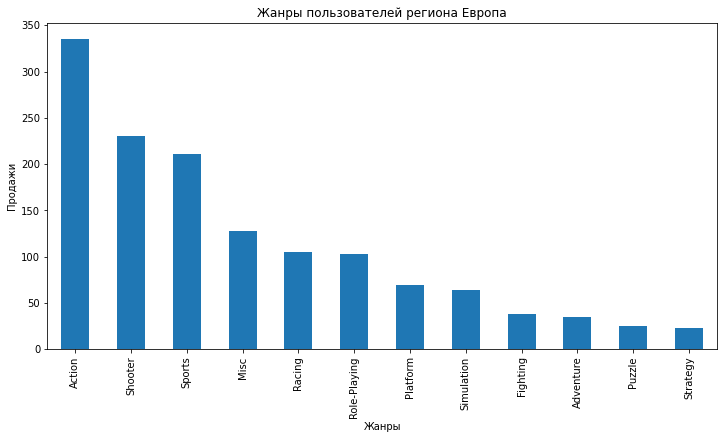

,eu_sales
genre,
Action,335.67
Shooter,230.16
Sports,211.49
Misc,127.62
Racing,104.63


In [581]:
top_region_genres['eu_sales'].sort_values(ascending = False).plot.bar(figsize = (12, 6))
plt.title('Жанры пользователей региона Европа')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()
top_five_genres('eu_sales')

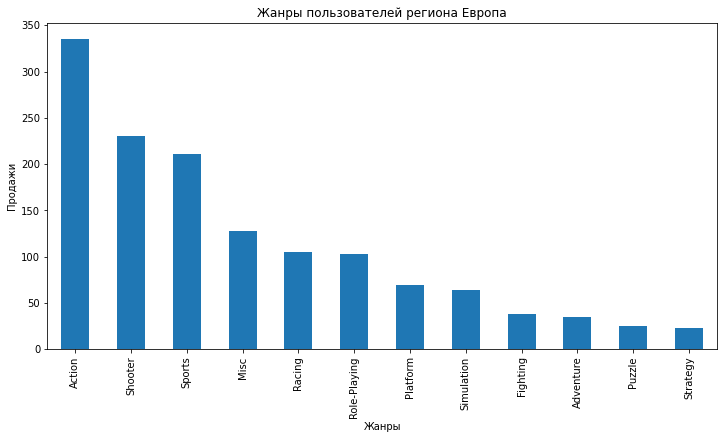

,eu_sales
genre,
Action,335.67
Shooter,230.16
Sports,211.49
Misc,127.62
Racing,104.63


In [582]:
top_region_genres['eu_sales'].sort_values(ascending = False).plot.bar(figsize = (12, 6))
plt.title('Жанры пользователей региона Европа')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()
top_five_genres('eu_sales')

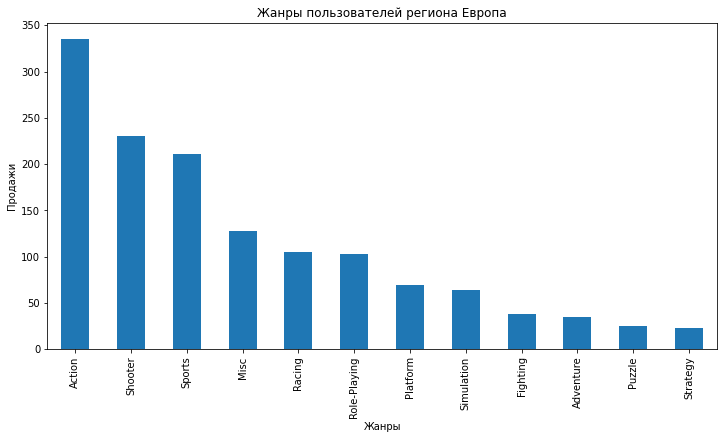

,eu_sales
genre,
Action,335.67
Shooter,230.16
Sports,211.49
Misc,127.62
Racing,104.63


In [583]:
top_region_genres['eu_sales'].sort_values(ascending = False).plot.bar(figsize = (12, 6))
plt.title('Жанры пользователей региона Европа')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()
top_five_genres('eu_sales')

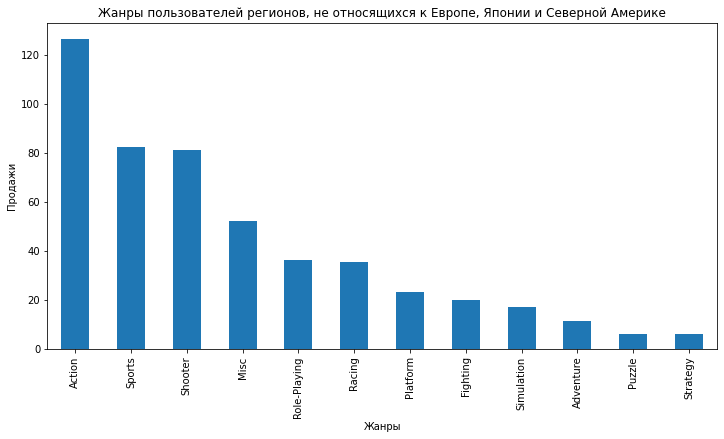

,other_sales
genre,
Action,126.46
Sports,82.44
Shooter,81.07
Misc,52.32
Role-Playing,36.40


In [584]:
top_region_genres['other_sales'].sort_values(ascending = False).plot.bar(figsize = (12, 6))
plt.title('Жанры пользователей регионов, не относящихся к Европе, Японии и Северной Америке')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()
top_five_genres('other_sales')

In [585]:
sales_per_genre_dict = {'Сумма продаж по топ-5 жанрам в регионе Европа:':
                         int(top_five_genres('eu_sales')['eu_sales'].sum()),
                         'Сумма продаж по топ-5 жанрам в регионе Япония:':
                         int(top_five_genres('jp_sales')['jp_sales'].sum()),
                         'Сумма продаж по топ-5 жанрам в регионе Северная Америка:':
                         int(top_five_genres('na_sales')['na_sales'].sum()),
                         'Сумма продаж по топ-5 жанрам в регионах не относящихся к Европе, Японии и Северной Америке':
                         int(top_five_genres('other_sales')['other_sales'].sum())}
for s in sorted(sales_per_genre_dict, key = sales_per_genre_dict.get):
    print(s, sales_per_genre_dict[s])

Сумма продаж по топ-5 жанрам в регионе Япония: 362
Сумма продаж по топ-5 жанрам в регионах не относящихся к Европе, Японии и Северной Америке 378
Сумма продаж по топ-5 жанрам в регионе Европа: 1009
Сумма продаж по топ-5 жанрам в регионе Северная Америка: 1600


Рейтинг топ-5 жанров одинаковый для Европы, Северной Америки и Японии.<br>
Эти жанры перечислены далее в формате от самых высоких продаж до самых низких:
- Action
- Sports
- Shooter
- Misc
- Racing

Единственное отличие топ-5 жанров в регионах не относящихся к Европе, Японии и Северной Америке - продажи по жанру Role-Playing здесь больше, чем по жанру Racing.

Далее значения выстроены по убыванию:
- Самые большие продажи зафиксированы в Северной Америке
- Европа (в 1.5 раза меньше продаж)
- Регионы не относящиеся к Европе, Японии и Северной Америке (отстаёт от Европы более чем в 2 раза)
- Япония (практически наравне с регионами не относящимися к Европе, Японии и Северной Америке )

In [586]:
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,28.32,87.0,8.4,E
13,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,22.70,80.0,7.7,E
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,21.82,61.0,6.3,E


In [587]:
ESRB = actual_data.pivot_table(index = 'rating',
                                        values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                        aggfunc = 'sum')
ESRB

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,393.08,95.06,663.99,138.48
E10+,162.75,31.91,287.61,61.97
EC,0.00,0.00,1.32,0.08
M,385.86,41.09,546.55,134.30
RP,0.03,0.00,0.00,0.01
T,217.89,74.74,371.32,94.12


In [588]:
ESRB_percent = ESRB.apply(lambda col: round((col / col.sum()), 2)* 100)
ESRB_percent

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,34.0,39.0,35.0,32.0
E10+,14.0,13.0,15.0,14.0
EC,0.0,0.0,0.0,0.0
M,33.0,17.0,29.0,31.0
RP,0.0,0.0,0.0,0.0
T,19.0,31.0,20.0,22.0


In [648]:
for rating in ESRB:
#     for region_sales in rating:
    print(rating)

eu_sales
jp_sales
na_sales
other_sales


In [653]:
ESRB_fract = ESRB.apply(lambda col: round((col / col.sum()), 2))
ESRB_fract

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,0.34,0.39,0.35,0.32
E10+,0.14,0.13,0.15,0.14
EC,0.00,0.00,0.00,0.00
M,0.33,0.17,0.29,0.31
RP,0.00,0.00,0.00,0.00
T,0.19,0.31,0.20,0.22


In [655]:
df_percent = ESRB_fract.style.format({
    'eu_sales': '{:,.0%}'.format,
    'jp_sales': '{:,.0%}'.format,
    'na_sales': '{:,.0%}'.format,
    'other_sales': '{:,.0%}'
})

df_percent

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,34%,39%,35%,32%
E10+,14%,13%,15%,14%
EC,0%,0%,0%,0%
M,33%,17%,29%,31%
RP,0%,0%,0%,0%
T,19%,31%,20%,22%


Рейтинг не столько влияет на продажи в отдельном регионе, сколько на продажи в целом. Это можно понять по тому, что в % каждый рейтинг влияет на продажи по всем регионам примерно в равной мере. На пример продажи при рейтинге E во всех регионах находятся в диапазоне от 34% (Европа) до 39% (Япония), а продажи при рейтинге RP, или EC везде по нулям.

**Выводы по портрету пользователя**

1. Самые популярные платформы по регионам.
- Самые большие продажи зафиксированы в Северной Америке. Топ 5 платформ: (PS3, X360, Wii, PS4, DS)
- В Европе почти в 2 раза меньше продаж, чем в Северной Америке. Топ 5 платформ:(DS, 3DS, PS3, PSP, Wii)
- Япония отстаёт от Европы по продажам более чем в 2 раза. Топ 5 платформ:(DS, 3DS, PS3, PSP, Wii)
- Регионы не относящиеся к Европе, Японии и Северной Америке находятся практически наравне с Японией. Топ 5 платформ: (PS3, X360, Wii, PS2, PS4)
2. Самые популярные жанры по регионам.

Рейтинг топ-5 жанров одинаковый для Европы, Северной Америки и Японии.<br>
Эти жанры перечислены далее в формате от самых высоких продаж до самых низких:
- Action
- Sports
- Shooter
- Misc
- Racing

Единственное отличие топ-5 жанров в регионах не относящихся к Европе, Японии и Северной Америке - продажи по жанру Role-Playing здесь больше, чем по жанру Racing.

Далее значения выстроены по убыванию:
- Самые большие продажи зафиксированы в Северной Америке
- Европа (в 1.5 раза меньше продаж)
- Регионы не относящиеся к Европе, Японии и Северной Америке (отстаёт от Европы более чем в 2 раза)
- Япония (практически наравне с регионами не относящимися к Европе, Японии и Северной Америке )

3. Рейтинг оказывает слабое влияние на продажи в отдельном регионе, однако сиьлно влияет на продажи в целом.

## 5. Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.<br>
H1: Средние пользовательские рейтинги платформ Xbox One и PC разные.

In [589]:
xone_rating = actual_data.query('platform == "XOne" and user_score != "NaN"')['user_score']
print('Средний пользовательский рейтинг платформы Xbox One:', xone_rating.mean())

pc_rating = actual_data.query('platform == "PC" and user_score != "NaN"')['user_score']
print('Средний пользовательский рейтинг платформы PC', pc_rating.mean())

print('Стандартное отклонение Xbox One:', np.std(xone_rating))
print('Стандартное отклонение PC:', np.std(pc_rating))

Средний пользовательский рейтинг платформы Xbox One: 6.52142857142857
Средний пользовательский рейтинг платформы PC 6.765499124343266
Стандартное отклонение Xbox One: 1.3771415462124992
Стандартное отклонение PC: 1.5284748145637863


In [590]:
results = st.ttest_ind(xone_rating, pc_rating, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.04401892858926169
Отвергаем нулевую гипотезу


Гипотеза была отвергнута, значит склоняемся к альтернативной гипотезе. Средние пользовательские рейтинги платформ Xbox One и PC разные.

Для проверки гипотезы променялся T-критерий Уэлча. Был сделан выбор именно в пользу критерия Уэлча потому что он позволяет учесть различия в дисперсиях выборок,в данном случае это актуально, так как стандартные отклонения Xbox One и PC отличаются.

### Средние пользовательские рейтинги жанров Action и Sports разные.

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые<br>
H1: Средние пользовательские рейтинги жанров Action и Sports разные

In [591]:
# добавили условия user_score !="NaN", так как из-за наличия в выборках значений NaN, 
# функция ttest_ind работала неправильно и выдавала p-value = nan
action_rating = actual_data.query('genre == "Action" and user_score != "NaN"')['user_score']
print('Средний пользовательский рейтинг жанра Action:', action_rating.mean())

sports_rating = actual_data.query('genre == "Sports" and user_score != "NaN"')['user_score']
print('Средний пользовательский рейтинг жанра Sports', sports_rating.mean())

print('Стандартное отклонение Action:', np.std(action_rating))
print('Стандартное отклонение Sports:', np.std(sports_rating))

Средний пользовательский рейтинг жанра Action: 6.836079077429997
Средний пользовательский рейтинг жанра Sports 6.307979626485568
Стандартное отклонение Action: 1.3522876268409818
Стандартное отклонение Sports: 1.6760838906252415


In [592]:
results = st.ttest_ind(action_rating, sports_rating, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 4.540665510055229e-11
Отвергаем нулевую гипотезу


Гипотеза была отвергнута, значит склоняемся к альтернативной гипотезе. Средние пользовательские рейтинги жанров Action и Sports разные, как и предполагалось.

Ситуация в выборе критерия в точности аналогична предыдущей.

## Общий вывод

В ходе работы мы выяснили следующее:
1. Больше всего игр вышло с 2003 по 2009 годы. Пик приходится на 2008 и 2009 годы. 
2. Самые большие продажи за всё время наблюдались у платформ PS, DS, Wii, PS3, X360 и PS2.
3. Характерный срок за который появляются новые и исчезают старые платформы составляет 7 лет и 7 месяцев.
4. Перспективные и неперспективные платформы:
    - Неперспективные:
        - Wii, X360, PS3, 3DS, PSV, WIIU
    - Перспективные
        - PS4, XOne, PC
5. Оценки пользователей и критиков:
    - Оценки пользователей не влияют на продажи платформ PS4, XOne, PC.
    - Оценки критиков не сильно влияют на продажи платформ PS4, XOne, PC. Их влияние на PC меньше, чем на PS4, XOne.
6. Прибыльность жанров:
    - Самые прибыльные жанры: action, shooter, sport.
    - Наименее прибыльные жанры: puzzle, strategy.
    
7. Самые популярные платформы по регионам.
- Самые большие продажи зафиксированы в Северной Америке. Топ 5 платформ: (PS3, X360, Wii, PS4, DS)
- В Европе почти в 2 раза меньше продаж, чем в Северной Америке. Топ 5 платформ:(DS, 3DS, PS3, PSP, Wii)
- Япония отстаёт от Европы по продажам более чем в 2 раза. Топ 5 платформ:(DS, 3DS, PS3, PSP, Wii)
- Регионы не относящиеся к Европе, Японии и Северной Америке находятся практически наравне с Японией. Топ 5 платформ: (PS3, X360, Wii, PS2, PS4)
8. Самые популярные жанры по регионам.

Рейтинг топ-5 жанров одинаковый для Европы, Северной Америки и Японии.<br>
Эти жанры перечислены далее в формате от самых высоких продаж до самых низких:
- Action
- Sports
- Shooter
- Misc
- Racing

Единственное отличие топ-5 жанров в регионах не относящихся к Европе, Японии и Северной Америке - продажи по жанру Role-Playing здесь больше, чем по жанру Racing.

Далее значения выстроены по убыванию:
- Самые большие продажи зафиксированы в Северной Америке
- Европа (в 1.5 раза меньше продаж)
- Регионы не относящиеся к Европе, Японии и Северной Америке (отстаёт от Европы более чем в 2 раза)
- Япония (практически наравне с регионами не относящимися к Европе, Японии и Северной Америке )

9. Рейтинг оказывает слабое влияние на продажи в отдельном регионе, однако сиьлно влияет на продажи в целом.
10. Средние пользовательские рейтинги платформ Xbox One и PC разные.
11.  Средние пользовательские рейтинги жанров Action и Sports разные.

Подводя итог из всего указанного выше, отмечается:

Наибольшее влияние на видеоигры оказывают следующие факторы:
- Год выхода игры
- Платформа
- Регион
- Жанр игры
- Рейтинг критиков
- Рейтинг ассоциации, определяющей возрастной рейтинг компьютерных игр

Предположительно наиболее продаваемыми будут игры, обладающие следующими свойствами (все свойства указаны в порядке "от лучшего к худшему"):
1. Относящиеся к жанрам: Action, Sports, Shooter, Misc, Racing
2. Расположенные на платформах: PS4, XOne, PC
3. Рейтинг ассоциации, определяющей возрастной рейтинг компьютерных игр которых: E, M, T, E10+
4. Отдельно следует отметить, что Число продаж по регионам расположено в следующем порядке (по тому же принципу, что и все свойства): Северная Амарика, Европа, Япония, регионы не относящиеся к Европе, Японии и Северной Америке

## Итоги работы

В ходе работы были выполнены следующие действия:

1. Обнаружены данные требующие обработки.
2. Приведены к нормальному виду названия столбцов данных
3. Преобразованы типы данных в столбцах `user_score` и `year_of_release`
4. Обработаны где нужно пустые значения
5. Добавлен столбец `total_sales` содержащий информацию о продажах во всех регионах
6. Разобрано и исправлено значение `tbd` в столбце с оценкой пользователей
7. выделен период, в который вышло наибольшее число игр
8. Выделен характерный срок за который появляются новые и исчезают старые платформы
9. Выделены платформы с самыми крупными продажами
10. Выделены перспективные и неперспективные платформы
11. Оценено влияние оценок критиков и пользователей
12. Выделены наиболее и наименее прибыльные жанры
13. Выделены самые популярные платформы по регионам
14. Выделены самые популярные жанры по регионам
15. Оценено влияние рейтинга на продажи как в отдельном регионе, так и в целом
16. Проверена гипотеза о средних пользовательских рейтингах платформ Xbox One и PC
17. Проверена гипотеза о средних пользовательских рейтингах жанров Action и Sports